In [1]:
# Every library that will be used in this project is imported at the start.

# Data handling and processing
import pandas as pd
import numpy as np

# Data visualisation & images
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline and machine learning algorithms
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# Model fine-tuning and evaluation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection

# Hide system warnings
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
# Data downloaded from Kaggle as a .csv file and read into this notebook from my local directory.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

ntrain = train.shape[0]
ntest = test.shape[0]

# Creating y_train variable; we'll need this when modelling, but not before
y_train = train['Survived'].values

# Saving the passenger ID's ready for our submission file at the very end
passId = test['PassengerId']

# Create a new all-encompassing dataset
data = pd.concat((train, test))

# Let's see some basic info about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [3]:
# Inspecting the first five rows, or 'observations'
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [4]:
# Returning descriptive statistics of the train dataset
data.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


In [5]:
# Provide NaN count for each feature in the dataset
print(data.isnull().sum())

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64


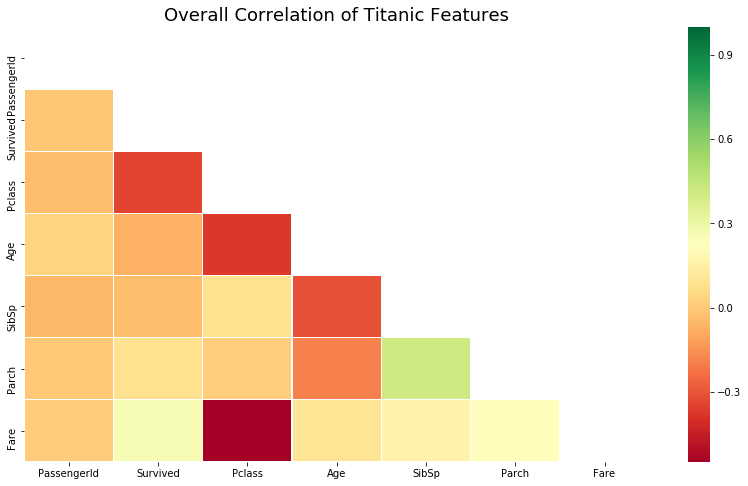

In [6]:
# Initiate correlation matrix
corr = train.corr()

# Set-up mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set-up figure
plt.figure(figsize=(14, 8))
# Title
plt.title('Overall Correlation of Titanic Features', fontsize=18)
# Correlation matrix
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

0    549
1    342
Name: Survived, dtype: int64


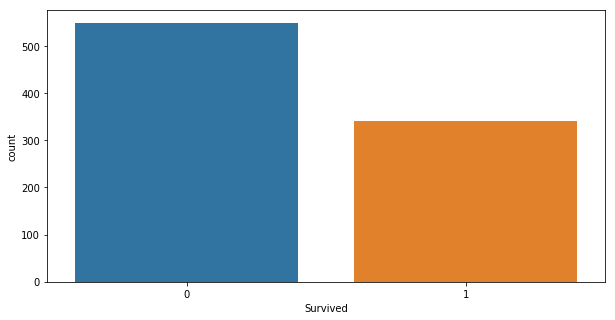

In [7]:
# Plot for survived
fig = plt.figure(figsize = (10,5))
sns.countplot(x='Survived', data = train)
print(train['Survived'].value_counts())

Text(0.5, 1.0, 'Percentage Survived by Ticket Class')

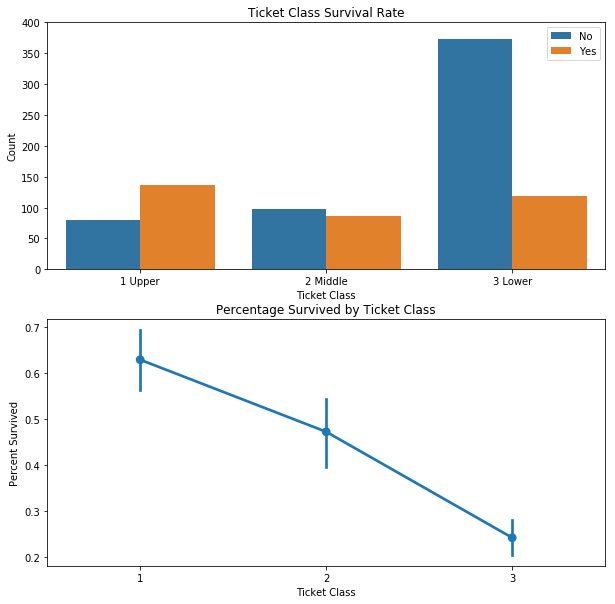

In [8]:
# Bar chart of each Pclass type
fig = plt.figure(figsize = (10,10))
ax1 = plt.subplot(2,1,1)
ax1 = sns.countplot(x = 'Pclass', hue = 'Survived', data = train)
ax1.set_title('Ticket Class Survival Rate')
ax1.set_xticklabels(['1 Upper','2 Middle','3 Lower'])
ax1.set_ylim(0,400)
ax1.set_xlabel('Ticket Class')
ax1.set_ylabel('Count')
ax1.legend(['No','Yes'])

# Pointplot Pclass type
ax2 = plt.subplot(2,1,2)
sns.pointplot(x='Pclass', y='Survived', data=train)
ax2.set_xlabel('Ticket Class')
ax2.set_ylabel('Percent Survived')
ax2.set_title('Percentage Survived by Ticket Class')

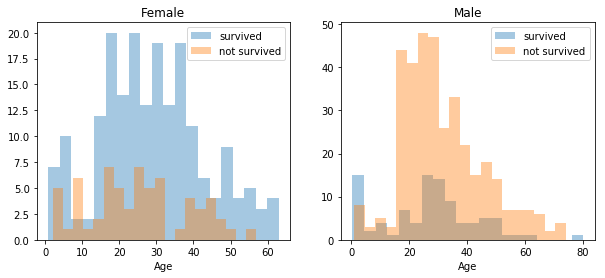

In [9]:
# Bar chart of age mapped against sex. For now, missing values have been dropped and will be dealt with later
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train[train['Sex']=='female']
men = train[train['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=20, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=20, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=20, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=20, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

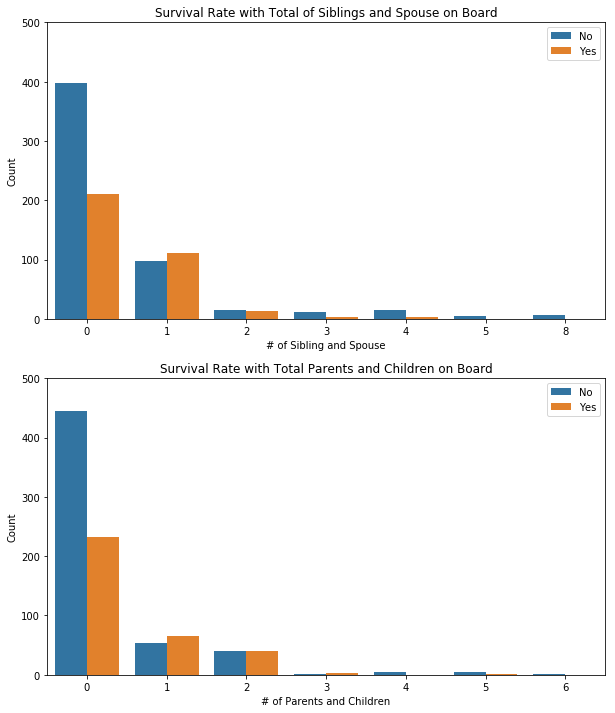

In [10]:
# Plotting survival rate vs Siblings or Spouse on board
fig = plt.figure(figsize = (10,12))
ax1 = plt.subplot(2,1,1)
ax1 = sns.countplot(x = 'SibSp', hue = 'Survived', data = train)
ax1.set_title('Survival Rate with Total of Siblings and Spouse on Board')
ax1.set_ylim(0,500)
ax1.set_xlabel('# of Sibling and Spouse')
ax1.set_ylabel('Count')
ax1.legend(['No','Yes'],loc = 1)

# Plotting survival rate vs Parents or Children on board
ax2 = plt.subplot(2,1,2)
ax2 = sns.countplot(x = 'Parch', hue = 'Survived', data = train)
ax2.set_title('Survival Rate with Total Parents and Children on Board')
ax2.set_ylim(0,500)
ax2.set_xlabel('# of Parents and Children')
ax2.set_ylabel('Count')
ax2.legend(['No','Yes'],loc = 1)

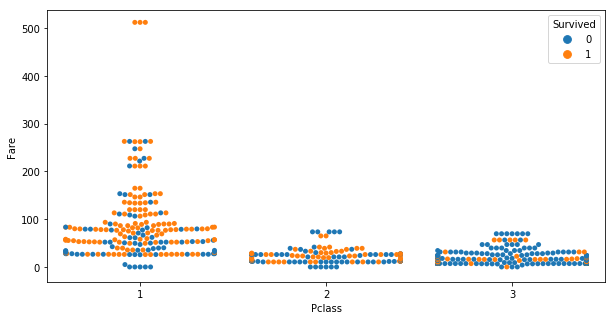

In [11]:
# Graph to display fare paid per the three ticket types
fig = plt.figure(figsize = (10,5))
sns.swarmplot(x="Pclass", y="Fare", data=train, hue='Survived')

In [12]:
# Extract last name
data['Last_Name'] = data['Name'].apply(lambda x: str.split(x, ",")[0])

# Fill in missing Fare value by overall Fare mean
data['Fare'].fillna(data['Fare'].mean(), inplace=True)

# Setting coin flip (e.g. random chance of surviving)
default_survival_chance = 0.5
data['Family_Survival'] = default_survival_chance

# Grouping data by last name and fare - looking for families
for grp, grp_df in data[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    # If not equal to 1, a family is found 
    # Then work out survival chance depending on whether or not that family member survived
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin == 0.0):
                data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 0

# Print the headline
print("Number of passengers with family survival information:", 
      data.loc[data['Family_Survival']!=0.5].shape[0])

Number of passengers with family survival information: 420


In [13]:
# If not equal to 1, a group member is found
# Then work out survival chance depending on whether or not that group member survived
for _, grp_df in data.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    data.loc[data['PassengerId'] == passID, 'Family_Survival'] = 0

# Print the headline
print("Number of passenger with family/group survival information: " 
      +str(data[data['Family_Survival']!=0.5].shape[0]))

Number of passenger with family/group survival information: 546


In [14]:
# Reset index for remaining feature engineering steps
data = data.reset_index(drop=True)
data = data.drop('Survived', axis=1)
data.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,Last_Name,Family_Survival
1304,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,A.5. 3236,Spector,0.5
1305,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,PC 17758,Oliva y Ocana,1.0
1306,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,SOTON/O.Q. 3101262,Saether,0.5
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,359309,Ware,0.5
1308,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,1309,3,male,1,2668,Peter,1.0


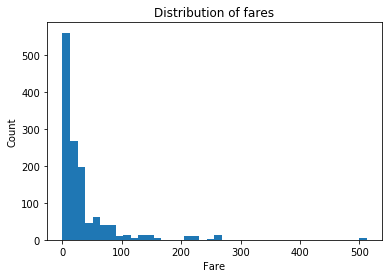

In [15]:
# Visualising fare data
plt.hist(data['Fare'], bins=40)
plt.xlabel('Fare')
plt.ylabel('Count')
plt.title('Distribution of fares')
plt.show()

Text(0.5, 1.0, 'Fare Bins')

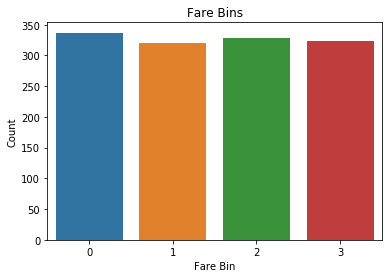

In [16]:
# Turning fare into 4 bins due to heavy skew in data
data['Fare'] = pd.qcut(data['Fare'], 4)

# I will now use Label Encoder to convert the bin ranges into numbers
lbl = LabelEncoder()
data['Fare'] = lbl.fit_transform(data['Fare'])

# Visualise new look fare variable
sns.countplot(data['Fare'])
plt.xlabel('Fare Bin')
plt.ylabel('Count')
plt.title('Fare Bins')

In [17]:
# New function to return name title only
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'Unknown'

# Creating two lists of titles, one for each dataset
titles_data = sorted(set([x for x in data['Name'].map(lambda x: get_title(x))]))

# Printing list length and items in each list
print(len(titles_data), ':', titles_data)

# New function to classify each title into 1 of 4 overarching titles
def set_title(x):
    title = x['Title']
    if title in ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Rev', 'Sir']:
        return 'Mr'
    elif title in ['the Countess', 'Mme', 'Lady','Dona']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
# Applying the get_title function to create the new 'Title' feature
data['Title'] = data['Name'].map(lambda x: get_title(x))
data['Title'] = data.apply(set_title, axis=1)

# Printing values of the title column (checking function worked!)
print(data['Title'].value_counts())

18 : ['Capt', 'Col', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess']
Mr        782
Miss      264
Mrs       202
Master     61
Name: Title, dtype: int64


Total missing age data:  263
count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64


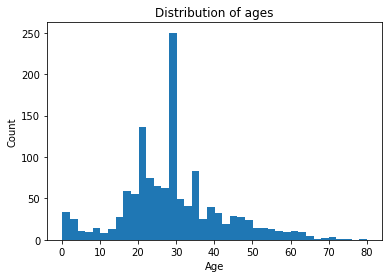

Text(0.5, 1.0, 'Age Bins')

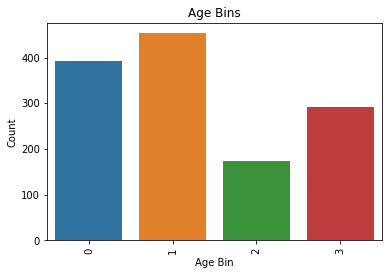

In [18]:
# Returning NaN within Age across Train & Test set
print('Total missing age data: ', pd.isnull(data['Age']).sum())

# Check which statistic to use in imputation
print(data['Age'].describe(exclude='NaN'))

# Imputing Age within the train & test set with the Median, grouped by Pclass and title
data['Age'] = data.groupby('Title')['Age'].apply(lambda x: x.fillna(x.median()))

# Visualise new look age variable
plt.hist(data['Age'], bins=40)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of ages')
plt.show()

# Turning data into 4 bins due to heavy skew in data
data['Age'] = pd.qcut(data['Age'], 4)

# Transforming bins to numbers
lbl = LabelEncoder()
data['Age'] = lbl.fit_transform(data['Age'])

# Visualise new look fare variable
plt.xticks(rotation='90')
sns.countplot(data['Age'])
plt.xlabel('Age Bin')
plt.ylabel('Count')
plt.title('Age Bins')

In [19]:
data['Title'] = data['Title'].replace(['Mr', 'Miss', 'Mrs', 'Master'], [0, 1, 2, 3])

# Recoding sex to numeric values with use of a dictionary for machine learning model compatibility
data['Sex'] = data['Sex'].replace(['male', 'female'], [0, 1])

In [20]:
data['Embarked'].describe()

# Filling in missing embarked values with the mode (S)
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

# Converting to numeric values
data['Embarked'] = data['Embarked'].replace(['S', 'C', 'Q'], [0, 1, 2])

In [21]:
# Labelling all NaN values as 'Unknown'
data['Cabin'].fillna('Unknown',inplace=True)

# Extracting the first value in the each row of Cabin
data['Cabin'] = data['Cabin'].map(lambda x: x[0])

# Return the counts of each unique value in the Cabin column
data['Cabin'].value_counts()

# New function to classify known cabins as 'Known', otherwise 'Unknown'
def unknown_cabin(cabin):
    if cabin != 'U':
        return 1
    else:
        return 0
    
# Applying new function to Cabin feature
data['Cabin'] = data['Cabin'].apply(lambda x:unknown_cabin(x))

In [22]:
# Creating two features of relatives and not alone
data['Family Size'] = data['SibSp'] + data['Parch']

In [23]:
# Final look at the data
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Ticket,Last_Name,Family_Survival,Title,Family Size
0,0,0,0,0,"Braund, Mr. Owen Harris",0,1,3,0,1,A/5 21171,Braund,0.5,0,1
1,3,1,1,3,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,PC 17599,Cumings,0.5,2,1
2,1,0,0,1,"Heikkinen, Miss. Laina",0,3,3,1,0,STON/O2. 3101282,Heikkinen,0.5,1,0
3,2,1,0,3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,113803,Futrelle,0.0,2,1
4,2,0,0,1,"Allen, Mr. William Henry",0,5,3,0,0,373450,Allen,0.5,0,0


In [24]:
# Dropping what we know need for Machine Learning
data = data.drop(['Name', 'Parch', 'SibSp', 'Ticket', 'Last_Name', 'PassengerId'], axis = 1)

In [25]:
# Return to train/test sets
train = data[:ntrain]
test = data[ntrain:]

In [26]:
# Set up feature and target variables in train set, and remove Passenger ID from test set
X_test = test
X_train = train

# Scaling data to support modelling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
# Initiate 11 classifier models
ran = RandomForestClassifier(random_state=1)
knn = KNeighborsClassifier()
log = LogisticRegression()
xgb = XGBClassifier()
gbc = GradientBoostingClassifier()
svc = SVC(probability=True)
ext = ExtraTreesClassifier()
ada = AdaBoostClassifier()
gnb = GaussianNB()
gpc = GaussianProcessClassifier()
bag = BaggingClassifier()

# Prepare lists
models = [ran, knn, log, xgb, gbc, svc, ext, ada, gnb, gpc, bag]
model_names = ['ran', 'knn', 'log', 'xgb', 'gbc', 'svc', 'ext', 'ada', 'gnb', 'gpc', 'bag']         
scores = []

# Sequentially fit and cross validate all models
for i in range(len(models)):
    mod = models[i]
    print('Fitting ' + model_names[i] + '...')
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 10)
    print('Accuracy: ' + str(acc.mean()))
    scores.append(acc.mean())

Fitting ran...
Accuracy: 0.8305209397344229
Fitting knn...
Accuracy: 0.8013440585631597
Fitting log...
Accuracy: 0.8473876404494384
Fitting xgb...
Accuracy: 0.856363920099875
Fitting gbc...
Accuracy: 0.8541042446941324
Fitting svc...
Accuracy: 0.8540789921688798
Fitting ext...
Accuracy: 0.823867041198502
Fitting ada...
Accuracy: 0.8417943479741232
Fitting gnb...
Accuracy: 0.8138298717512201
Fitting gpc...
Accuracy: 0.8439791170128249
Fitting bag...
Accuracy: 0.8192971853365112


In [28]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': ['Random Forest', 'K Nearest Neighbour', 'Logistic Regression', 'XGBoost', 'Gradient Boosting', 'SVC', 'Extra Trees', 'AdaBoost', 'Gaussian Naive Bayes', 'Gaussian Process', 'Bagging Classifier'],
    'Score': scores})

result_df = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
result_df.head(11)

,Model,Score
0,XGBoost,0.856364
1,Gradient Boosting,0.854104
2,SVC,0.854079
3,Logistic Regression,0.847388
4,Gaussian Process,0.843979
5,AdaBoost,0.841794
6,Random Forest,0.830521
7,Extra Trees,0.823867
8,Bagging Classifier,0.819297
9,Gaussian Naive Bayes,0.813830


(0.8, 0.86)

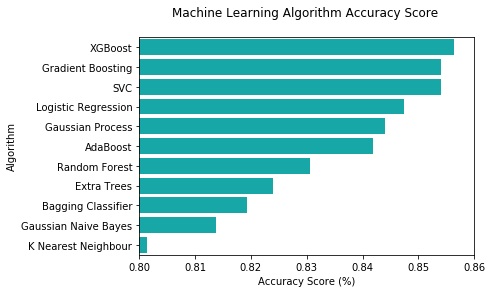

In [29]:
# Plot results
sns.barplot(x='Score', y = 'Model', data = result_df, color = 'c')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')
plt.xlim(0.80, 0.86)

In [30]:
# Function for new graph
def importance_plotting(data, x, y, palette, title):
    sns.set(style="whitegrid")
    ft = sns.PairGrid(data, y_vars=y, x_vars=x, size=5, aspect=1.5)
    ft.map(sns.stripplot, orient='h', palette=palette, edgecolor="black", size=15)
    
    for ax, title in zip(ft.axes.flat, titles):
    # Set a different title for each axes
        ax.set(title=title)
    # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
    plt.show()

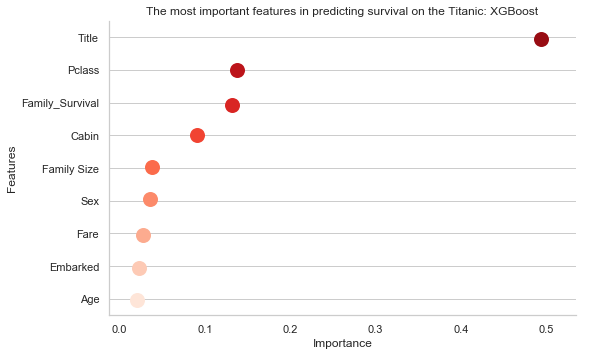

In [31]:
# Building feature importance into a DataFrame
fi = {'Features':train.columns.tolist(), 'Importance':xgb.feature_importances_}
importance = pd.DataFrame(fi, index=None).sort_values('Importance', ascending=False)

# Creating graph title
titles = ['The most important features in predicting survival on the Titanic: XGBoost']

# Plotting graph
importance_plotting(importance, 'Importance', 'Features', 'Reds_r', titles)

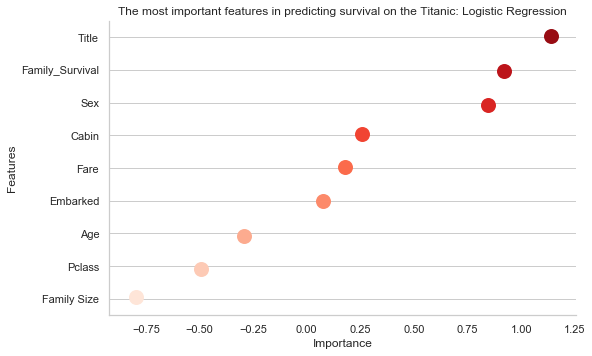

In [32]:
# Building feature importance into a DataFrame
fi = {'Features':train.columns.tolist(), 'Importance':np.transpose(log.coef_[0])}
importance = pd.DataFrame(fi, index=None).sort_values('Importance', ascending=False)

# Creating graph title
titles = ['The most important features in predicting survival on the Titanic: Logistic Regression']

# Plotting graph
importance_plotting(importance, 'Importance', 'Features', 'Reds_r', titles)

In [33]:
# Getting feature importances for the 5 models where we can
gbc_imp = pd.DataFrame({'Feature':train.columns, 'gbc importance':gbc.feature_importances_})
xgb_imp = pd.DataFrame({'Feature':train.columns, 'xgb importance':xgb.feature_importances_})
ran_imp = pd.DataFrame({'Feature':train.columns, 'ran importance':ran.feature_importances_})
ext_imp = pd.DataFrame({'Feature':train.columns, 'ext importance':ext.feature_importances_})
ada_imp = pd.DataFrame({'Feature':train.columns, 'ada importance':ada.feature_importances_})

# Merging results into a single dataframe
importances = gbc_imp.merge(xgb_imp, on='Feature').merge(ran_imp, on='Feature').merge(ext_imp, on='Feature').merge(ada_imp, on='Feature')

# Calculating average importance per feature
importances['Average'] = importances.mean(axis=1)

# Ranking top to bottom
importances = importances.sort_values(by='Average', ascending=False).reset_index(drop=True)

# Display
importances

,Feature,gbc importance,xgb importance,ran importance,ext importance,ada importance,Average
0,Title,0.525984,0.493975,0.264317,0.184376,0.14,0.321730
1,Family_Survival,0.210392,0.132249,0.146282,0.142534,0.14,0.154291
2,Pclass,0.123275,0.138155,0.099272,0.085724,0.12,0.113285
3,Family Size,0.036266,0.037675,0.089831,0.081349,0.26,0.101024
4,Sex,0.001924,0.035564,0.157222,0.258067,0.02,0.094555
5,Age,0.024701,0.021103,0.088934,0.075143,0.16,0.073976
6,Cabin,0.038215,0.090474,0.042673,0.066371,0.06,0.059547
7,Fare,0.030821,0.027483,0.066060,0.063826,0.04,0.045638
8,Embarked,0.008423,0.023322,0.045410,0.042610,0.06,0.035953


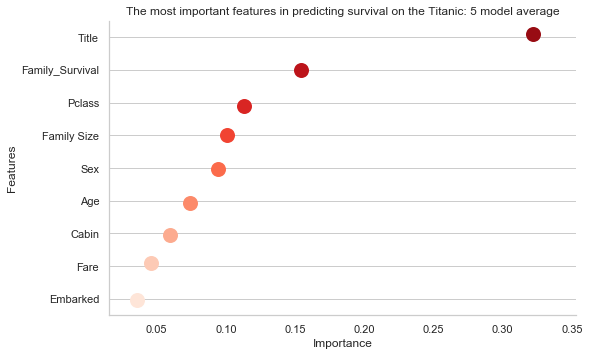

In [34]:
# Building feature importance into a DataFrame
fi = {'Features':importances['Feature'], 'Importance':importances['Average']}
importance = pd.DataFrame(fi, index=None).sort_values('Importance', ascending=False)

# Creating graph title
titles = ['The most important features in predicting survival on the Titanic: 5 model average']

# Plotting graph
importance_plotting(importance, 'Importance', 'Features', 'Reds_r', titles)

In [35]:
# Drop redundant features
train = train.drop(['Embarked', 'Cabin'], axis=1)
test = test.drop(['Embarked', 'Cabin'], axis=1)

# Re-build model variables
X_train = train
X_test = test

# Transform
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
# Initiate models
ran = RandomForestClassifier(random_state=1)
knn = KNeighborsClassifier()
log = LogisticRegression()
xgb = XGBClassifier(random_state=1)
gbc = GradientBoostingClassifier(random_state=1)
svc = SVC(probability=True)
ext = ExtraTreesClassifier(random_state=1)
ada = AdaBoostClassifier(random_state=1)
gnb = GaussianNB()
gpc = GaussianProcessClassifier()
bag = BaggingClassifier(random_state=1)

# Lists
models = [ran, knn, log, xgb, gbc, svc, ext, ada, gnb, gpc, bag]         
scores_v2 = []

# Fit & cross validate
for i in range(len(models)):
    mod = models[i]
    print('Fitting ' + model_names[i] + '...')
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 10)
    print('Accuracy: ' + str(acc.mean()))
    scores_v2.append(acc.mean())

Fitting ran...
Accuracy: 0.840633015548746
Fitting knn...
Accuracy: 0.8497227896946997
Fitting log...
Accuracy: 0.848523720349563
Fitting xgb...
Accuracy: 0.8563258994438769
Fitting gbc...
Accuracy: 0.8563134150493701
Fitting svc...
Accuracy: 0.857437294291227
Fitting ext...
Accuracy: 0.837324934740665
Fitting ada...
Accuracy: 0.8372996822154125
Fitting gnb...
Accuracy: 0.8227048575644081
Fitting gpc...
Accuracy: 0.8574747474747475
Fitting bag...
Accuracy: 0.8417313585291113


In [37]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': ['Random Forest', 'K Nearest Neighbour', 'Logistic Regression', 'XGBoost', 'Gradient Boosting', 'SVC', 'Extra Trees', 'AdaBoost', 'Gaussian Naive Bayes', 'Gaussian Process', 'Bagging Classifier'],
    'Original Score': scores,
    'Score with feature selection': scores_v2})

result_df = results.sort_values(by='Score with feature selection', ascending=False).reset_index(drop=True)
result_df.head(11)

,Model,Original Score,Score with feature selection
0,Gaussian Process,0.843979,0.857475
1,SVC,0.854079,0.857437
2,XGBoost,0.856364,0.856326
3,Gradient Boosting,0.854104,0.856313
4,K Nearest Neighbour,0.801344,0.849723
5,Logistic Regression,0.847388,0.848524
6,Bagging Classifier,0.819297,0.841731
7,Random Forest,0.830521,0.840633
8,Extra Trees,0.823867,0.837325
9,AdaBoost,0.841794,0.837300


(0.8, 0.86)

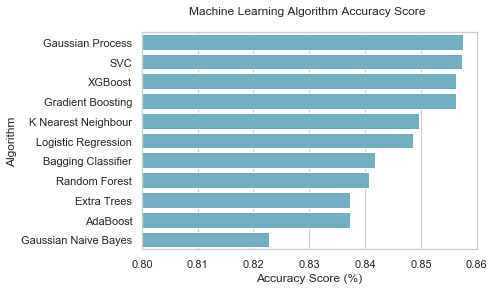

In [38]:
# Plot results
sns.barplot(x='Score with feature selection', y = 'Model', data = result_df, color = 'c')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')
plt.xlim(0.80, 0.86)

In [39]:
# Parameter's to search
Cs = [0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 50, 100]
gammas = [0.001, 0.01, 0.1, 1]

# Setting up parameter grid
hyperparams = {'C': Cs, 'gamma' : gammas}

# Run GridSearch CV
gd=GridSearchCV(estimator = SVC(probability=True), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy")

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.856341189674523
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    7.4s finished


In [40]:
# Parameter's to search
learning_rate = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
n_estimators = [100, 250, 500, 750, 1000, 1250, 1500]

# Setting up parameter grid
hyperparams = {'learning_rate': learning_rate, 'n_estimators': n_estimators}

# Run GridSearch CV
gd=GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy")

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:  1.8min finished


0.856341189674523
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.0005, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1250,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [41]:
# Parameter's to search
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)

# Setting up parameter grid
hyperparams = {'penalty': penalty, 'C': C}

# Run GridSearch CV
gd=GridSearchCV(estimator = LogisticRegression(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy")

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.8507295173961841
LogisticRegression(C=2.7825594022071245, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [42]:
max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
min_child_weight = [1, 2, 3, 4, 5, 6]

hyperparams = {'max_depth': max_depth, 'min_child_weight': min_child_weight}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.0001, n_estimators=10), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy")

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.856341189674523
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.0001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    1.5s finished


In [43]:
gamma = [i*0.1 for i in range(0,5)]

hyperparams = {'gamma': gamma}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.0001, n_estimators=10, max_depth=3, 
                                          min_child_weight=1), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy")

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.856341189674523
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.0,
              learning_rate=0.0001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


In [44]:
subsample = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
colsample_bytree = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    
hyperparams = {'subsample': subsample, 'colsample_bytree': colsample_bytree}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.0001, n_estimators=10, max_depth=3, 
                                          min_child_weight=1, gamma=0), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy")

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.856341189674523
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0,
              learning_rate=0.0001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.65, verbosity=1)


[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:    2.3s finished


In [45]:
reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
    
hyperparams = {'reg_alpha': reg_alpha}

gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.0001, n_estimators=10, max_depth=3, 
                                          min_child_weight=1, gamma=0, subsample=0.6, colsample_bytree=0.9),
                                         param_grid = hyperparams, verbose=True, cv=5, scoring = "accuracy")

gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.8529741863075196
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.0001, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=1e-05, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


In [46]:
# Parameter's to search
n_restarts_optimizer = [0, 1, 2, 3]
max_iter_predict = [1, 2, 5, 10, 20, 35, 50, 100]
warm_start = [True, False]

# Setting up parameter grid
hyperparams = {'n_restarts_optimizer': n_restarts_optimizer, 'max_iter_predict': max_iter_predict, 'warm_start': warm_start}

# Run GridSearch CV
gd=GridSearchCV(estimator = GaussianProcessClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy")

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.856341189674523
GaussianProcessClassifier(copy_X_train=True, kernel=None, max_iter_predict=1,
                          multi_class='one_vs_rest', n_jobs=None,
                          n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
                          random_state=None, warm_start=False)


[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:   36.9s finished


In [47]:
# Parameter's to search
n_estimators = [10, 25, 50, 75, 100, 125, 150, 200]
learning_rate = [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2]

# Setting up parameter grid
hyperparams = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

# Run GridSearch CV
gd=GridSearchCV(estimator = AdaBoostClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy")

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8473625140291807
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=50, random_state=None)


[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:   27.4s finished


In [48]:
# Parameter's to search
n_estimators = [10, 25, 50, 75, 100, 125, 150, 200]
learning_rate = [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2]

# Setting up parameter grid
hyperparams = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

# Run GridSearch CV
gd=GridSearchCV(estimator = AdaBoostClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy")

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 56 candidates, totalling 280 fits
0.8473625140291807
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=50, random_state=None)


[Parallel(n_jobs=1)]: Done 280 out of 280 | elapsed:   27.3s finished


In [49]:
# Parameter's to search
n_estimators = [10, 25, 50, 75, 100]
max_depth = [3, None]
max_features = [1, 3, 5, 7]
min_samples_split = [2, 4, 6, 8, 10]
min_samples_leaf = [2, 4, 6, 8, 10]

# Setting up parameter grid
hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# Run GridSearch CV
gd=GridSearchCV(estimator = RandomForestClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy")

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8608305274971941
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:  4.5min finished


In [50]:
# Parameter's to search
n_estimators = [10, 25, 50, 75, 100]
max_depth = [3, None]
max_features = [1, 3, 5, 7]
min_samples_split = [2, 4, 6, 8, 10]
min_samples_leaf = [2, 4, 6, 8, 10]

# Setting up parameter grid
hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 'max_features': max_features,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# Run GridSearch CV
gd=GridSearchCV(estimator = ExtraTreesClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy")

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.856341189674523
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=3, max_features=5, max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=8, min_samples_split=6,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)


[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:  3.5min finished


In [51]:
# Parameter's to search
n_estimators = [10, 15, 20, 25, 50, 75, 100, 150]
max_samples = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 50]
max_features = [1, 3, 5, 7]

# Setting up parameter grid
hyperparams = {'n_estimators': n_estimators, 'max_samples': max_samples, 'max_features': max_features}

# Run GridSearch CV
gd=GridSearchCV(estimator = BaggingClassifier(), param_grid = hyperparams, 
                verbose=True, cv=5, scoring = "accuracy")

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 352 candidates, totalling 1760 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8552188552188552
BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=5, max_samples=50, n_estimators=75, n_jobs=None,
                  oob_score=False, random_state=None, verbose=0,
                  warm_start=False)


[Parallel(n_jobs=1)]: Done 1760 out of 1760 | elapsed:  1.6min finished


In [52]:
# Initiate tuned models
ran = RandomForestClassifier(n_estimators=25,
                             max_depth=3, 
                             max_features=3,
                             min_samples_leaf=2, 
                             min_samples_split=8,  
                             random_state=1)

knn = KNeighborsClassifier(algorithm='auto', 
                           leaf_size=1, 
                           n_neighbors=5, 
                           weights='uniform')

log = LogisticRegression(C=2.7825594022071245,
                         penalty='l2')

xgb = XGBClassifier(learning_rate=0.0001, 
                    n_estimators=10,
                    random_state=1)

gbc = GradientBoostingClassifier(learning_rate=0.0005,
                                 n_estimators=1250,
                                 random_state=1)

svc = SVC(probability=True)

ext = ExtraTreesClassifier(max_depth=None, 
                           max_features=3,
                           min_samples_leaf=2, 
                           min_samples_split=8,
                           n_estimators=10,
                           random_state=1)

ada = AdaBoostClassifier(learning_rate=0.1, 
                         n_estimators=50,
                         random_state=1)

gpc = GaussianProcessClassifier()

bag = BaggingClassifier(random_state=1)

# Lists
models = [ran, knn, log, xgb, gbc, svc, ext, ada, gnb, gpc, bag]         
scores_v3 = []
  
# Fit & cross validate
for i in range(len(models)):
    mod = models[i]
    print('Fitting ' + model_names[i] + '...')
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "accuracy", cv = 10)
    print('Accuracy: ' + str(acc.mean()))
    scores_v3.append(acc.mean())

Fitting ran...
Accuracy: 0.8529301441380092
Fitting knn...
Accuracy: 0.8496728521166723
Fitting log...
Accuracy: 0.848523720349563
Fitting xgb...
Accuracy: 0.8563012143911021
Fitting gbc...
Accuracy: 0.8563012143911021
Fitting svc...
Accuracy: 0.857437294291227
Fitting ext...
Accuracy: 0.8574622630802405
Fitting ada...
Accuracy: 0.849584326410169
Fitting gnb...
Accuracy: 0.8227048575644081
Fitting gpc...
Accuracy: 0.8574747474747475
Fitting bag...
Accuracy: 0.8417313585291113


In [53]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': ['Random Forest', 'K Nearest Neighbour', 'Logistic Regression', 'XGBoost', 'Gradient Boosting', 'SVC', 'Extra Trees', 'AdaBoost', 'Gaussian Naive Bayes', 'Gaussian Process', 'Bagging Classifier'],
    'Original Score': scores,
    'Score with feature selection': scores_v2,
    'Score with tuned parameters': scores_v3})

result_df = results.sort_values(by='Score with tuned parameters', ascending=False).reset_index(drop=True)
result_df.head(11)

,Model,Original Score,Score with feature selection,Score with tuned parameters
0,Gaussian Process,0.843979,0.857475,0.857475
1,Extra Trees,0.823867,0.837325,0.857462
2,SVC,0.854079,0.857437,0.857437
3,XGBoost,0.856364,0.856326,0.856301
4,Gradient Boosting,0.854104,0.856313,0.856301
5,Random Forest,0.830521,0.840633,0.852930
6,K Nearest Neighbour,0.801344,0.849723,0.849673
7,AdaBoost,0.841794,0.837300,0.849584
8,Logistic Regression,0.847388,0.848524,0.848524
9,Bagging Classifier,0.819297,0.841731,0.841731


(0.82, 0.86)

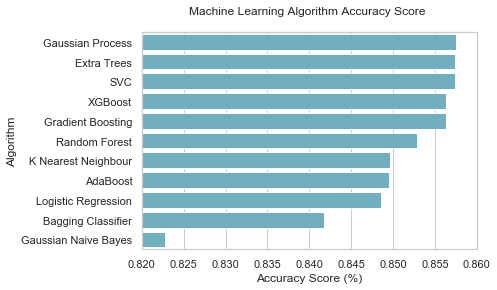

In [54]:
# Plot results
sns.barplot(x='Score with tuned parameters', y = 'Model', data = result_df, color = 'c')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')
plt.xlim(0.82, 0.86)

In [61]:
#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = VotingClassifier(estimators = [('Random Forest', ran), 
                                           ('Logistic Regression', log),
                                           ('XGBoost', xgb),
                                           ('Gradient Boosting', gbc),
                                           ('Extra Trees', ext),
                                           ('AdaBoost', ada),
                                           ('Gaussian Process', gpc),
                                           ('SVC', svc),
                                           ('K Nearest Neighbour', knn),
                                           ('Bagging Classifier', bag)], voting = 'hard')

grid_hard_cv = model_selection.cross_validate(grid_hard, X_train, y_train, cv = 10)
grid_hard.fit(X_train, y_train)

# print("Hard voting on train set score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard voting on train set score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))

Hard voting on train set score mean: 85.52


In [62]:
grid_soft = VotingClassifier(estimators = [('Random Forest', ran), 
                                           ('Logistic Regression', log),
                                           ('XGBoost', xgb),
                                           ('Gradient Boosting', gbc),
                                           ('Extra Trees', ext),
                                           ('AdaBoost', ada),
                                           ('Gaussian Process', gpc),
                                           ('SVC', svc),
                                           ('K Nearest Neighbour', knn),
                                           ('Bagging Classifier', bag)], voting = 'soft')

grid_soft_cv = model_selection.cross_validate(grid_soft, X_train, y_train, cv = 10)
grid_soft.fit(X_train, y_train)

# print("Soft voting on train set score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft voting on train set score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))

Soft voting on train set score mean: 86.20


In [ ]:
# Final predictions
predictions = grid_soft.predict(X_test)

submission = pd.concat([pd.DataFrame(passId), pd.DataFrame(predictions)], axis = 'columns')

submission.columns = ["PassengerId", "Survived"]
submission.to_csv('titanic_submission.csv', header = True, index = False)